In [1]:
# !git clone https://github.com/hyperforest/seisbench.git
# !pip install -e seisbench

In [1]:
import numpy as np
from pathlib import Path as _Path
from torchsummary import summary
import torch
import seaborn as sns

%load_ext autoreload
%autoreload 2
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import matplotlib.pyplot as plt
import copy
from utils import Solver, ProbabilisticLabeller
from blocks import *
import logging
from leqnet import LEQNet

seisbench.cache_root = _Path("../")
seisbench.cache_data_root = _Path("../datasets/")
seisbench.cache_model_root = seisbench.cache_root / 'models' / 'v3'
# seisbench.remote_model_root = 'https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/models/v3/'
# seisbench.config = {'dimension_order': 'NCW', 'component_order': 'ZNE'}
# seisbench.__version__ = '0.5.2'

# logger = logging.getLogger('seisbench')
# logger.setLevel(logging.INFO)
# seisbench.logger = logger


In [2]:
data = sbd.Iquique(sampling_rate=100)
df_meta = data.metadata
mask = (~df_meta['trace_P_arrival_sample'].isna() &
        ~df_meta['trace_S_arrival_sample'].isna())

data.filter(mask)

train, val, test = data.train_dev_test()

train_generator = sbg.GenericGenerator(train)
val_generator = sbg.GenericGenerator(val)
test_generator = sbg.GenericGenerator(test)


2024-01-04 11:33:03,411 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


5830


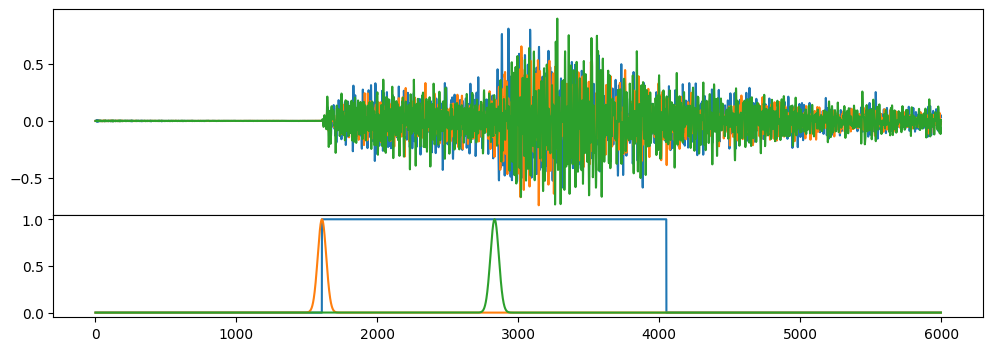

In [3]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S"
}

preprocessing = [
    sbg.RandomWindow(windowlen=6000, strategy="move"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.Filter(btype='bandpass', Wn=[2,25], N=6),
    sbg.ChangeDtype(np.float32),
    ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=1, use_detection=True, spectrogram_based=True)
]
train_augmentation = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=2000, windowlen=8000, selection="first", strategy="pad"),
    *preprocessing,
]

# meniadakan augmentasi random window untuk data pengujian
test_preprocessing = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=2000, windowlen=6000, selection="first", strategy="pad"),
    *preprocessing,
]

train_generator.add_augmentations(train_augmentation)
val_generator.add_augmentations(train_augmentation)
test_generator.add_augmentations(test_preprocessing)

n = np.random.randint(len(train_generator))
# n=1175
print(n)
sample = train_generator[n]

fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)
plt.show()

In [4]:
pt_data = "iquique"
model_pt = sbm.EQTransformer.from_pretrained(pt_data, update=True)
model_base = sbm.EQTransformer()

model_eqt = copy.deepcopy(model_pt)
model_leq = copy.deepcopy(model_pt)
model_leq_plus = copy.deepcopy(model_pt)

# replace encoder and decoder using separable conv1d
encoder = EncoderSepConv1d(
    input_channels=model_pt.in_channels,
    filters=model_pt.filters,
    kernel_sizes=model_pt.kernel_sizes,
    in_samples=model_pt.in_samples
)
model_eqt.encoder = model_base.encoder
model_leq.encoder = encoder
model_leq_plus.encoder = encoder

decoder = DecoderSepConv1d(
    input_channels=16,
    filters=model_pt.filters[::-1],
    kernel_sizes=model_pt.kernel_sizes[::-1],
    out_samples=model_pt.in_samples,
)

model_eqt.decoder_d = model_base.decoder_d 
model_leq.decoder_d = decoder
model_leq_plus.encoder = decoder

pick_decoders = [decoder for _ in range(2)]
model_eqt.pick_decoders = nn.ModuleList(pick_decoders)
model_leq.pick_decoders = nn.ModuleList(pick_decoders)
model_leq_plus.pick_decoders = nn.ModuleList(pick_decoders)

# replace res cnn stack to deeper bottleneck
deeper_bottleneck = DeeperBottleneckStack(
  kernel_sizes=model_pt.res_cnn_kernels,
  filters=model_pt.filters[-1],
  drop_rate=model_pt.drop_rate,
)
model_eqt.res_cnn_stack = model_base.res_cnn_stack
model_leq.res_cnn_stack = deeper_bottleneck
model_leq_plus.res_cnn_stack = deeper_bottleneck

# replace single head to multi head transformer
Transformer = MultiHeadTransformerPreLN
num_heads = 8

model_eqt.transformer_d0 = model_base.transformer_d0
model_leq.transformer_d0 = model_base.transformer_d0
model_leq_plus.transformer_d0 = Transformer(
  input_size=16, drop_rate=model_pt.drop_rate, num_heads=num_heads, eps=1e-5
)

model_eqt.transformer_d = model_base.transformer_d
model_leq.transformer_d = model_base.transformer_d
model_leq_plus.transformer_d = Transformer(
  input_size=16, drop_rate=model_pt.drop_rate, num_heads=num_heads, eps=1e-5
)

# pick_attentios = [nn.MultiheadAttention(embed_dim=16, num_heads=num_heads) for _ in range(2)]
# model_eqt.pick_attentions = model_base.pick_attentions
# model_leq.pick_attentions = nn.ModuleList(pick_attentios)

for model in [model_eqt, model_leq, model_leq_plus]:
  for name, param in model.named_parameters():
    if 'lstm' in name:
      param.requires_grad = False


In [44]:
for bs in [32]:
  for lr in [1e-3]:
    folder_name = f'{pt_data}/LEQNet_bs{bs}_lr{lr}'
    model = copy.deepcopy(model_leq).to(device='mps')

    config = dict(
      main = dict(
        batch_size=bs, 
        folder_name=folder_name,
        class_weights=[.02, .40, .58],
        patience=50,
        ),
      train = dict (
        model= model, 
        learning_rate=lr,
        epochs=50,
        print_every_batch=20,
      ),
      test = dict(
        model_path=folder_name,
        model_base=model,
        plot_batch_id=[i for i in range(bs)],
        dT=400
      )
    )

    solver = Solver(train_generator, val_generator, test_generator, **config['main'])
    solver.train(**config['train'])
    solver.test(**config['test'])


Epoch 1, Learning Rate: 0.001
-------------------------------
[   32/ 6718] loss: 0.580449 | loss_d: 0.690453 | loss_p: 0.552304 | loss_s: 0.596065 | f1_d: 0.000000 | f1_p: 0.030527 | f1_s: 0.030527
[  672/ 6718] loss: 0.337018 | loss_d: 0.693171 | loss_p: 0.374575 | loss_s: 0.298836 | f1_d: 0.000000 | f1_p: 0.030152 | f1_s: 0.000000
[ 1312/ 6718] loss: 0.114415 | loss_d: 0.688469 | loss_p: 0.128645 | loss_s: 0.084807 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 1952/ 6718] loss: 0.084635 | loss_d: 0.699538 | loss_p: 0.066304 | loss_s: 0.076073 | f1_d: 0.000145 | f1_p: 0.000000 | f1_s: 0.000000
[ 2592/ 6718] loss: 0.080915 | loss_d: 0.693254 | loss_p: 0.069745 | loss_s: 0.067504 | f1_d: 0.000190 | f1_p: 0.000000 | f1_s: 0.000000
[ 3232/ 6718] loss: 0.080327 | loss_d: 0.702514 | loss_p: 0.067490 | loss_s: 0.067726 | f1_d: 0.000013 | f1_p: 0.000000 | f1_s: 0.000000
[ 3872/ 6718] loss: 0.079718 | loss_d: 0.685388 | loss_p: 0.067154 | loss_s: 0.067498 | f1_d: 0.000111 | f1_p: 0.00

Saving plot..:   0%|          | 0/108 [00:04<?, ?it/s]



Epoch 2, Learning Rate: 0.001
-------------------------------
[   32/ 6718] loss: 0.079399 | loss_d: 0.691651 | loss_p: 0.066671 | loss_s: 0.067066 | f1_d: 0.000027 | f1_p: 0.000000 | f1_s: 0.000000
[  672/ 6718] loss: 0.079521 | loss_d: 0.692023 | loss_p: 0.066873 | loss_s: 0.067122 | f1_d: 0.000113 | f1_p: 0.000000 | f1_s: 0.000000
[ 1312/ 6718] loss: 0.080002 | loss_d: 0.690423 | loss_p: 0.067531 | loss_s: 0.067553 | f1_d: 0.000085 | f1_p: 0.000000 | f1_s: 0.000000
[ 1952/ 6718] loss: 0.079515 | loss_d: 0.691468 | loss_p: 0.066579 | loss_s: 0.067334 | f1_d: 0.000054 | f1_p: 0.000000 | f1_s: 0.000000
[ 2592/ 6718] loss: 0.079602 | loss_d: 0.687079 | loss_p: 0.066518 | loss_s: 0.067678 | f1_d: 0.000178 | f1_p: 0.000000 | f1_s: 0.000000
[ 3232/ 6718] loss: 0.079087 | loss_d: 0.683305 | loss_p: 0.065805 | loss_s: 0.067412 | f1_d: 0.000056 | f1_p: 0.000000 | f1_s: 0.000000
[ 3872/ 6718] loss: 0.078862 | loss_d: 0.683736 | loss_p: 0.065309 | loss_s: 0.067350 | f1_d: 0.000031 | f1_p: 0.00

Saving plot..:   0%|          | 0/108 [00:05<?, ?it/s]



Epoch 3, Learning Rate: 0.001
-------------------------------
[   32/ 6718] loss: 0.078026 | loss_d: 0.689973 | loss_p: 0.063693 | loss_s: 0.066809 | f1_d: 0.000112 | f1_p: 0.000000 | f1_s: 0.000000
[  672/ 6718] loss: 0.078919 | loss_d: 0.673422 | loss_p: 0.066400 | loss_s: 0.067053 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 1312/ 6718] loss: 0.078005 | loss_d: 0.701102 | loss_p: 0.062870 | loss_s: 0.066957 | f1_d: 0.000109 | f1_p: 0.000000 | f1_s: 0.000000
[ 1952/ 6718] loss: 0.077809 | loss_d: 0.687099 | loss_p: 0.063134 | loss_s: 0.066919 | f1_d: 0.000080 | f1_p: 0.000000 | f1_s: 0.000000
[ 2592/ 6718] loss: 0.077854 | loss_d: 0.677567 | loss_p: 0.064268 | loss_s: 0.066543 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 3232/ 6718] loss: 0.076695 | loss_d: 0.689316 | loss_p: 0.060816 | loss_s: 0.066522 | f1_d: 0.000048 | f1_p: 0.000000 | f1_s: 0.000000
[ 3872/ 6718] loss: 0.077707 | loss_d: 0.680353 | loss_p: 0.063556 | loss_s: 0.066686 | f1_d: 0.000059 | f1_p: 0.00

Saving plot..:   0%|          | 0/108 [00:09<?, ?it/s]



Epoch 4, Learning Rate: 0.001
-------------------------------
[   32/ 6718] loss: 0.077212 | loss_d: 0.667195 | loss_p: 0.063926 | loss_s: 0.066030 | f1_d: 0.000042 | f1_p: 0.000000 | f1_s: 0.000000
[  672/ 6718] loss: 0.077245 | loss_d: 0.682396 | loss_p: 0.063085 | loss_s: 0.066144 | f1_d: 0.000014 | f1_p: 0.000000 | f1_s: 0.000000
[ 1312/ 6718] loss: 0.076676 | loss_d: 0.681615 | loss_p: 0.062374 | loss_s: 0.065680 | f1_d: 0.000039 | f1_p: 0.000000 | f1_s: 0.000000
[ 1952/ 6718] loss: 0.077087 | loss_d: 0.677615 | loss_p: 0.062914 | loss_s: 0.066154 | f1_d: 0.000014 | f1_p: 0.000000 | f1_s: 0.000000
[ 2592/ 6718] loss: 0.078416 | loss_d: 0.668590 | loss_p: 0.064519 | loss_s: 0.067649 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 3232/ 6718] loss: 0.076547 | loss_d: 0.665866 | loss_p: 0.063034 | loss_s: 0.065544 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 3872/ 6718] loss: 0.077550 | loss_d: 0.662221 | loss_p: 0.062975 | loss_s: 0.067440 | f1_d: 0.000000 | f1_p: 0.00

Saving plot..:   0%|          | 0/108 [00:08<?, ?it/s]



Epoch 5, Learning Rate: 0.001
-------------------------------
[   32/ 6718] loss: 0.076690 | loss_d: 0.669052 | loss_p: 0.062983 | loss_s: 0.065717 | f1_d: 0.000011 | f1_p: 0.000000 | f1_s: 0.000000
[  672/ 6718] loss: 0.077109 | loss_d: 0.684545 | loss_p: 0.063826 | loss_s: 0.065325 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 1312/ 6718] loss: 0.077865 | loss_d: 0.666273 | loss_p: 0.064942 | loss_s: 0.066487 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 1952/ 6718] loss: 0.077929 | loss_d: 0.672771 | loss_p: 0.064621 | loss_s: 0.066595 | f1_d: 0.000013 | f1_p: 0.000000 | f1_s: 0.000000
[ 2592/ 6718] loss: 0.078402 | loss_d: 0.663807 | loss_p: 0.065142 | loss_s: 0.067359 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 3232/ 6718] loss: 0.076486 | loss_d: 0.657176 | loss_p: 0.062195 | loss_s: 0.066318 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 3872/ 6718] loss: 0.077048 | loss_d: 0.669510 | loss_p: 0.063180 | loss_s: 0.066183 | f1_d: 0.601322 | f1_p: 0.00

Saving plot..:   0%|          | 0/108 [00:07<?, ?it/s]



Epoch 6, Learning Rate: 0.001
-------------------------------
[   32/ 6718] loss: 0.076188 | loss_d: 0.666696 | loss_p: 0.062624 | loss_s: 0.065179 | f1_d: 0.000013 | f1_p: 0.000000 | f1_s: 0.000000
[  672/ 6718] loss: 0.077657 | loss_d: 0.671998 | loss_p: 0.065633 | loss_s: 0.065456 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 1312/ 6718] loss: 0.076232 | loss_d: 0.668160 | loss_p: 0.062335 | loss_s: 0.065405 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 1952/ 6718] loss: 0.076892 | loss_d: 0.673684 | loss_p: 0.063131 | loss_s: 0.065803 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 2592/ 6718] loss: 0.076693 | loss_d: 0.661334 | loss_p: 0.064133 | loss_s: 0.065195 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 3232/ 6718] loss: 0.078550 | loss_d: 0.674055 | loss_p: 0.066739 | loss_s: 0.066161 | f1_d: 0.000028 | f1_p: 0.000000 | f1_s: 0.000000
[ 3872/ 6718] loss: 0.077864 | loss_d: 0.683878 | loss_p: 0.065095 | loss_s: 0.065773 | f1_d: 0.000000 | f1_p: 0.00

KeyboardInterrupt: 

In [42]:

solver.save_history()
solver.save_plot()
solver.save_summary()
# solver.train_loop(solver.train_loader)


Saving plot..:   0%|          | 0/108 [00:16<?, ?it/s]


In [22]:
solver.picker_thres=0.55
solver.plot_hist(base_model=copy.deepcopy(model_leq), n=0)

saving_plot..: 100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


[test] f1_d: 0.951985 | f1_p: 0.707525 | f1_s: 0.490056


In [21]:
solver.picker_thres=0.1
solver.plot_hist(base_model=copy.deepcopy(model_leq), n=0)

saving_plot..: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]


[test] f1_d: 0.951079 | f1_p: 0.799653 | f1_s: 0.727027


In [12]:
import json
from scipy import stats
import statsmodels.api as sm
import pandas as pd

def snr_dist_compare(path1, path2, model_label, dT=500):
  fig, axs = plt.subplots(1,3, figsize=(12,4))
  colors = ['red', 'blue']
  data_means = []
  data_normality = []
  for p,path in enumerate([path1, path2]):
    with open(path/f'test_dT{dT}'/'dist_SNR.json', 'r') as f:
      data = json.load(f)
    mean_values = []
    norm_values = []
    for i,label in enumerate(['p', 's', 'd']):
      selected_data = np.array(data[label])
      if p>0: selected_data = selected_data[-mask:]
      
      statistic, p_value = stats.shapiro(selected_data)
      mean = np.mean(selected_data)
      sns.histplot(selected_data, ax=axs[i], bins=50, alpha=0.07, kde=True, stat='frequency', color=colors[p], label=model_label[p]+f' ({statistic:.3f})', edgecolor=None)
      axs[i].axvline(mean, color=colors[p], linewidth=1, linestyle='dashed')
      
      title = 'Pick P' if label=='p' else 'Pick S' if label=='s' else 'Pick CODA'
      axs[i].set_title(title)
      axs[i].set_xlabel('SNR db')
      handles, labels = axs[i].get_legend_handles_labels()
      axs[i].legend(handles, labels)
      axs[i].set_xlim(0,60) if 'd' != label else axs[i].set_xlim(-20,2)
      
      mean_values.append(f"{mean:.2f}")
      norm_values.append(f"{statistic:.3f}")

    data_means.append(mean_values)
    data_normality.append(norm_values)
    
    if p==0: mask = len(selected_data)
    print(len(selected_data))

  plt.tight_layout()
  plt.savefig(f'snr_compare_dT{dT}.png')
  df = pd.DataFrame(data_means, columns=['Pick P', 'Pick S', 'Pick CODA'], index=model_label)
  df2 = pd.DataFrame(data_normality, columns=['Pick P', 'Pick S', 'Pick CODA'], index=model_label)
  print('Mean of SNR Distribution')
  display(df)

  print('Normality using Shapiro-Wilk test')
  display(df2)

path1 = _Path('outputs/iquique/EQTransformer_bs32_lr0.001')
path2 = _Path('outputs/iquique/LEQNet+_bs32_lr0.001')

snr_dist_compare(path1, path2, ['EQTransformer', 'LEQNet+'], 400)

Mean of SNR Distribution


,Pick P,Pick S,Pick CODA
EQTransformer,33.48,11.45,-2.71
LEQNet+,31.11,11.35,-3.76


Normality using Shapiro-Wilk test


,Pick P,Pick S,Pick CODA
EQTransformer,0.984,0.831,0.958
LEQNet+,0.994,0.912,0.999
